# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

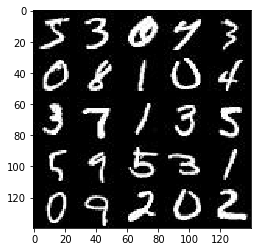

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

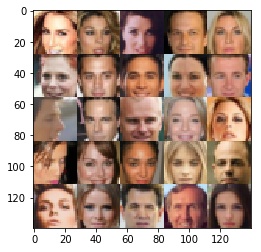

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input    = tf.placeholder(tf.float32, 
                                   (None, image_width, image_height, image_channels), 
                                   name='real_input')
    
    z_input       = tf.placeholder(tf.float32, 
                                   (None, z_dim), 
                                   name='z_input')
    
    learning_rate = tf.placeholder(tf.float32, 
                                   name='learning_rate')
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [52]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #
    # The paper proposes and stddev=0.02 for variables initialization and it works fine
    # here as well.
    #
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # conv 1 
        layers = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(alpha * layers, layers)
        
        # conv 2
        conv1 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding="SAME",
                                kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        relu2 = tf.maximum(alpha * conv1, conv1)
        
        # conv 3
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="SAME", 
                                 kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * conv3, conv3)
        
        # flatten
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1, 
                                 kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [78]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # 
    # Here, I am doing just ReLU instead of LeakyReLU, as proposed by https://arxiv.org/pdf/1511.06434.pdf
    #
    with tf.variable_scope('generator', reuse=not is_train):
        
        # Fully connected layer
        layer = tf.layers.dense(z, 7*7*256)   
        
       
        layer = tf.reshape(layer, (-1, 7, 7, 256))
        #layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha * layer, layer)
        
        # conv 1                              
        conv1 = tf.layers.conv2d_transpose(layer, 128, 5, strides=2, padding='same', 
                                 kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        relu1 = tf.nn.relu(conv1)
        #relu1 = tf.maximum(alpha * conv1, conv1)
        
        # conv 2 
        conv2 = tf.layers.conv2d_transpose(relu1, 64, 5, strides=2, padding='same', 
                                 kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.nn.relu(conv2)
        #relu2 = tf.maximum(alpha * conv2, conv2)
                      
        # Output layer
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, 
                                            strides=1, padding='same', 
                                            kernel_initializer = tf.random_normal_initializer(stddev=0.02))
      
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [79]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """    
    smooth = 0.1
    
    # Creating the models
    # Generator
    g_model = generator(input_z, out_channel_dim, is_train=True)    
    
    # Discriminator
    d_model_real, d_logits_real = discriminator(input_real)    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    # Calculate losses 
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))     
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [80]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # A brief explanation:
    #
    # My first attempt was:
    # 
    # update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    # g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    # d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    #
    # with tf.control_dependencies(g_updates):
    #     g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    # with tf.control_dependencies(d_updates):
    #    d_train_opt = tf.train.AdamOptimizer(learning_rate, 
    #                                     beta1=beta1).minimize(d_loss, var_list=d_vars) 
    #
    # In my opinion it is more elegant, but I didn't find enough resources to make sure if it is the right way ... 

    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] 
            
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                             beta1).minimize(g_loss, var_list=g_vars)
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                             beta1).minimize(d_loss, var_list=d_vars)    

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [81]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [82]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Building the model
    #
    # Commenting tf.reset_default_graph() after read:
    # https://discussions.udacity.com/t/project-facegeneration-indexerror-list-index-out-of-range/246401/12
    #
    #tf.reset_default_graph()
    
    _, image_width, image_height, image_channels = data_shape
        
    input_real, input_z, lr = model_inputs(image_width, 
                                           image_height, 
                                           image_channels, 
                                           z_dim)
    
    d_loss, g_loss = model_loss(input_real, 
                                input_z, 
                                image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Training Algorithm
    show_output  = 100
    print_output = 20
    steps        = 0   
                      
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images*2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z})
                
                # including batch_images here, to avoid error in batch_normalization. 
                # tip given by the users on #project 5 in SLACK.
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z})
                
                # trick from https://github.com/carpedm20/DCGAN-tensorflow/blob/master/model.py#L245
                # by calling generator twice the results are better
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z}) 
                
                if steps % print_output == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_z: batch_z, 
                                                               input_real: batch_images})
                    
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_output == 0:     
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        
        # show the last one =)
        _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.8209... Generator Loss: 0.0488
Epoch 1/2... Discriminator Loss: 2.3549... Generator Loss: 0.5247
Epoch 1/2... Discriminator Loss: 2.7992... Generator Loss: 0.1873
Epoch 1/2... Discriminator Loss: 2.6085... Generator Loss: 0.1522
Epoch 1/2... Discriminator Loss: 2.0352... Generator Loss: 0.2628


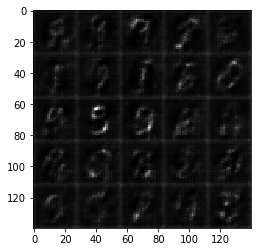

Epoch 1/2... Discriminator Loss: 1.7588... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.6532... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 1.6183... Generator Loss: 0.8807
Epoch 1/2... Discriminator Loss: 1.9050... Generator Loss: 0.4248


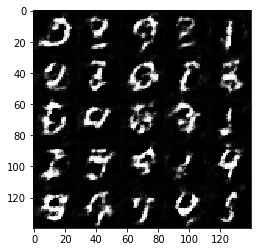

Epoch 1/2... Discriminator Loss: 1.7815... Generator Loss: 0.4622
Epoch 1/2... Discriminator Loss: 1.6746... Generator Loss: 0.4593
Epoch 1/2... Discriminator Loss: 2.0750... Generator Loss: 0.3010
Epoch 1/2... Discriminator Loss: 1.7863... Generator Loss: 0.4093
Epoch 1/2... Discriminator Loss: 1.8224... Generator Loss: 0.3544


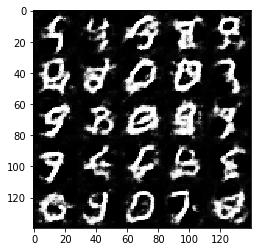

Epoch 1/2... Discriminator Loss: 1.7323... Generator Loss: 0.4312
Epoch 1/2... Discriminator Loss: 1.4049... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.6331... Generator Loss: 0.4891
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.8669
Epoch 1/2... Discriminator Loss: 1.5901... Generator Loss: 0.6257


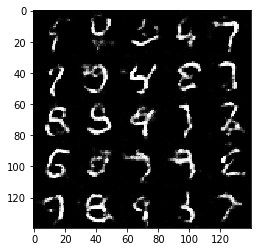

Epoch 1/2... Discriminator Loss: 1.5765... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.6485... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 1.5527... Generator Loss: 0.5580
Epoch 1/2... Discriminator Loss: 1.6568... Generator Loss: 0.4533


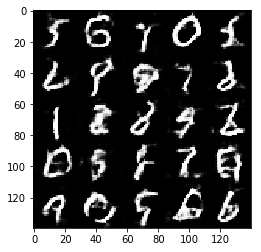

Epoch 1/2... Discriminator Loss: 1.6061... Generator Loss: 0.4541
Epoch 1/2... Discriminator Loss: 1.5757... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 1.6028... Generator Loss: 1.3371
Epoch 1/2... Discriminator Loss: 2.5328... Generator Loss: 0.1467
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.5166


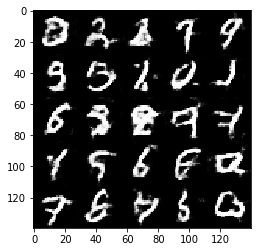

Epoch 1/2... Discriminator Loss: 1.7364... Generator Loss: 0.4015
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.9524
Epoch 1/2... Discriminator Loss: 1.5402... Generator Loss: 0.5430
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.6164
Epoch 1/2... Discriminator Loss: 1.5748... Generator Loss: 0.5269


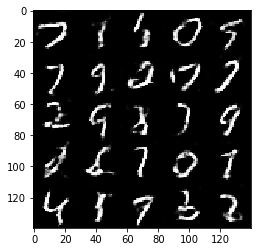

Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.6050
Epoch 1/2... Discriminator Loss: 1.8192... Generator Loss: 0.3091
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.9443
Epoch 1/2... Discriminator Loss: 1.5038... Generator Loss: 0.6851
Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 0.6303


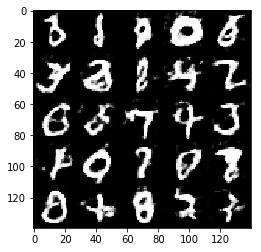

Epoch 1/2... Discriminator Loss: 1.6718... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 1.4571... Generator Loss: 1.3990
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 1.4939... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 0.5633


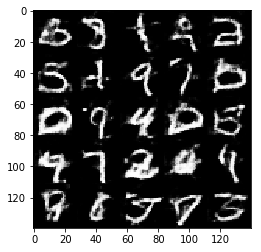

Epoch 1/2... Discriminator Loss: 2.0299... Generator Loss: 0.2391
Epoch 2/2... Discriminator Loss: 1.5614... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 1.5686... Generator Loss: 0.4959
Epoch 2/2... Discriminator Loss: 1.6473... Generator Loss: 1.3328
Epoch 2/2... Discriminator Loss: 1.5381... Generator Loss: 0.5423


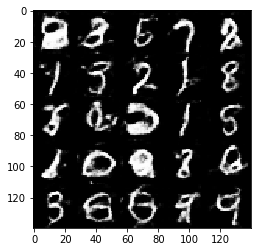

Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.4853... Generator Loss: 0.8919
Epoch 2/2... Discriminator Loss: 1.6189... Generator Loss: 0.5234
Epoch 2/2... Discriminator Loss: 1.6308... Generator Loss: 0.4776
Epoch 2/2... Discriminator Loss: 1.4470... Generator Loss: 0.7230


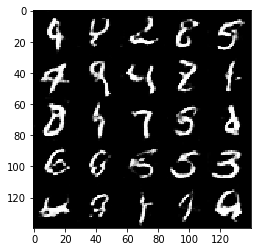

Epoch 2/2... Discriminator Loss: 2.0707... Generator Loss: 1.9048
Epoch 2/2... Discriminator Loss: 1.4202... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.5189... Generator Loss: 0.6220
Epoch 2/2... Discriminator Loss: 1.6910... Generator Loss: 0.3801
Epoch 2/2... Discriminator Loss: 1.4611... Generator Loss: 0.8004


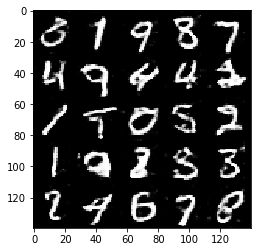

Epoch 2/2... Discriminator Loss: 1.7203... Generator Loss: 0.3524
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 1.4087... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.5888... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 0.6948


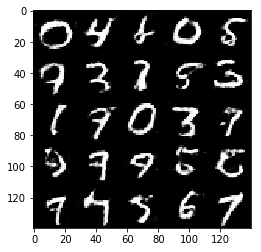

Epoch 2/2... Discriminator Loss: 1.7131... Generator Loss: 0.3772
Epoch 2/2... Discriminator Loss: 1.7030... Generator Loss: 1.2004
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.5322... Generator Loss: 0.5160
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 0.5320


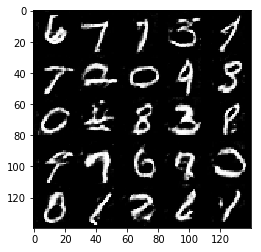

Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.7838... Generator Loss: 0.3272
Epoch 2/2... Discriminator Loss: 1.7696... Generator Loss: 0.3758
Epoch 2/2... Discriminator Loss: 1.7124... Generator Loss: 0.3881


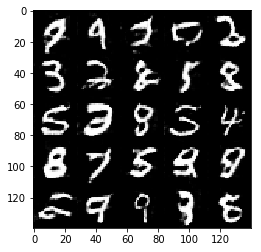

Epoch 2/2... Discriminator Loss: 1.5993... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.6404... Generator Loss: 1.1965
Epoch 2/2... Discriminator Loss: 1.6663... Generator Loss: 0.3991
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 0.6210


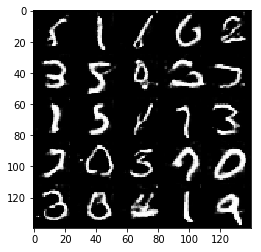

Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 1.1448
Epoch 2/2... Discriminator Loss: 1.4983... Generator Loss: 0.5524
Epoch 2/2... Discriminator Loss: 1.4842... Generator Loss: 0.7092
Epoch 2/2... Discriminator Loss: 1.6397... Generator Loss: 0.4458
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 1.0326


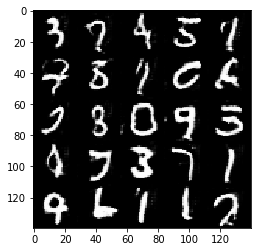

Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 1.8548... Generator Loss: 1.6113
Epoch 2/2... Discriminator Loss: 1.5429... Generator Loss: 1.2238
Epoch 2/2... Discriminator Loss: 1.5020... Generator Loss: 0.5966


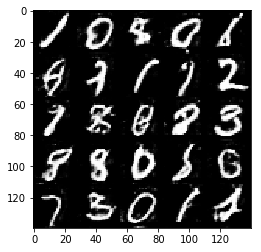

Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 1.4328... Generator Loss: 1.3140
Epoch 2/2... Discriminator Loss: 1.4814... Generator Loss: 1.3812


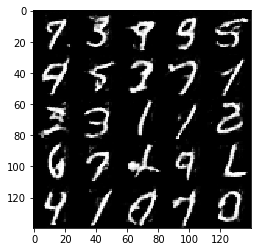

In [83]:
# the paper proposes batch_size = 128 and learning rate = 0.0002, which ensures the learnin stability, 
# however, as I didn't implemented the full model, here batch_size = 64 and learning_rate = 0.0004 were better
batch_size = 64
z_dim = 100
learning_rate = 0.0004 
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2414... Generator Loss: 2.1991
Epoch 1/1... Discriminator Loss: 3.4342... Generator Loss: 0.2978
Epoch 1/1... Discriminator Loss: 2.8227... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 2.1410... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.7151


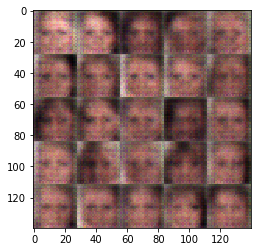

Epoch 1/1... Discriminator Loss: 1.8168... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 1.6354... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.7957... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.8925... Generator Loss: 0.6299


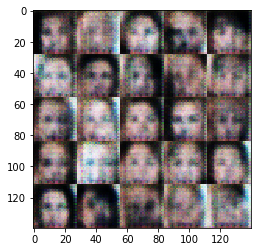

Epoch 1/1... Discriminator Loss: 1.6294... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.6910... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.6066... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.8619... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.6538


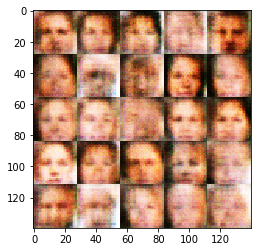

Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.7169


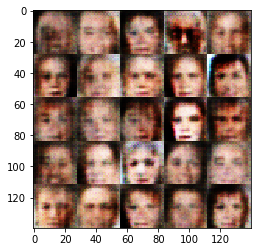

Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.7262... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.5972


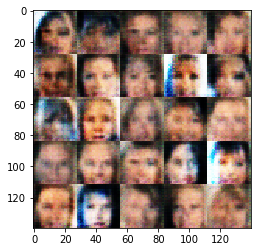

Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 0.9062


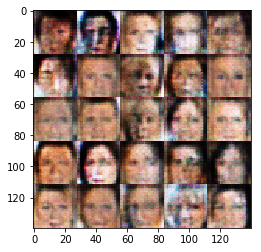

Epoch 1/1... Discriminator Loss: 1.6684... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.6977... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.7436... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.6986... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.7713


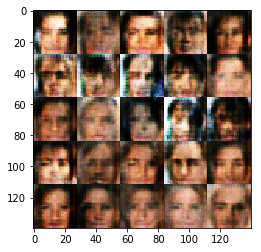

Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.6609


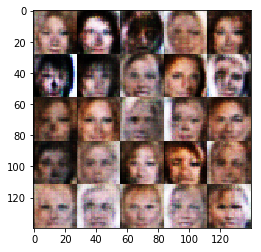

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.8458


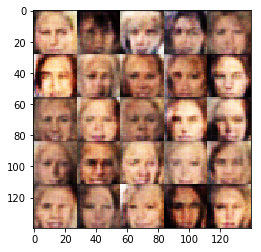

Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7164


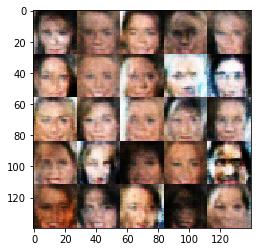

Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7447


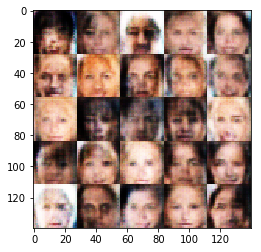

Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8155


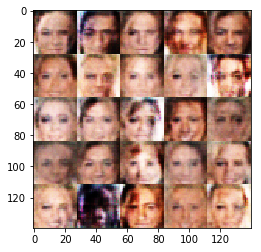

Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6956


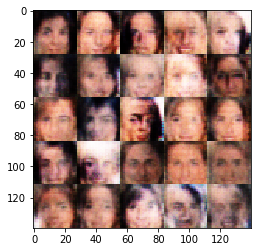

Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.5997... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7396


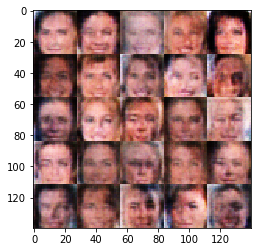

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.8039


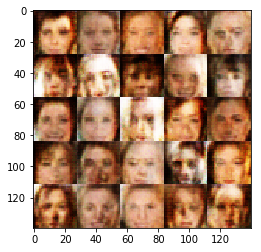

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7194


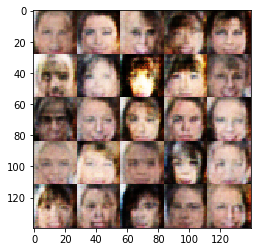

Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7408


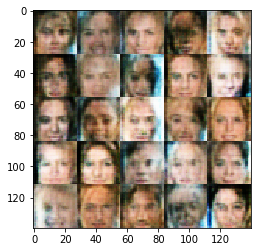

Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7152


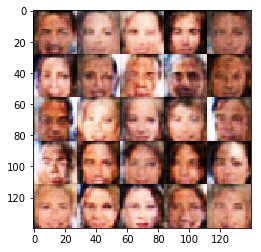

Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7490


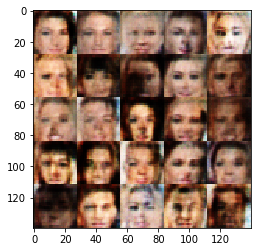

Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.8066


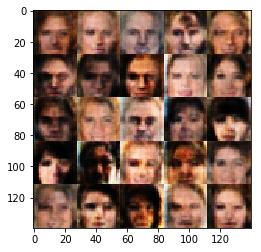

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8641


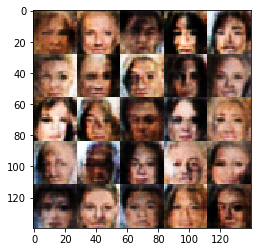

Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.7556


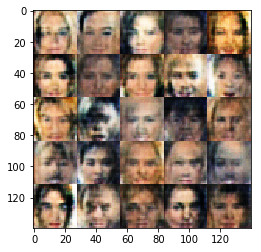

Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.7925


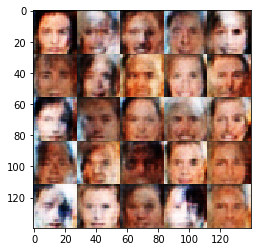

Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7748


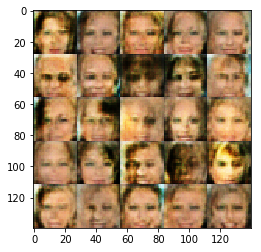

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.7847


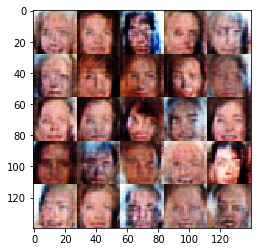

Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.7390


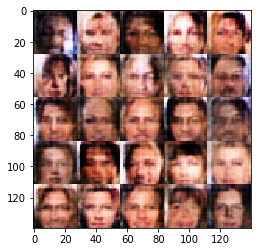

Epoch 1/1... Discriminator Loss: 1.6442... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7858


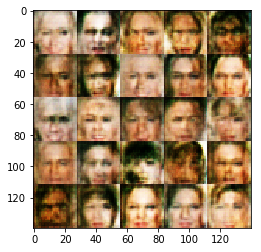

Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.9111


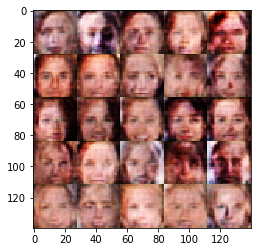

Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7037


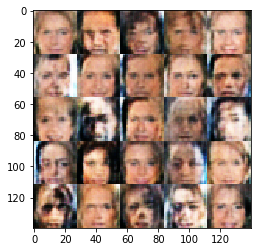

Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7501


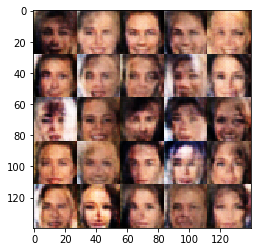

Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8329


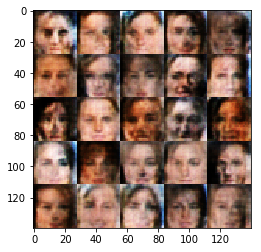

Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.8557


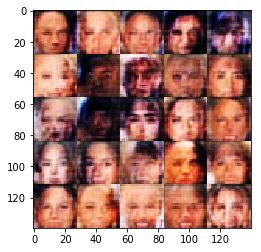

In [84]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.